In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/ANN_Backbropagation/Homework2/Data
#%cd /gdrive/My Drive/Colab Notebooks/ANN_Backbropagation/Homework2/Data

Mounted at /gdrive
/gdrive/My Drive/ANN_Backbropagation/Homework2/Data


In [ ]:
# General purpose libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# t-SNE library
from sklearn.manifold import TSNE

# Data Import

In [ ]:
# If the folder "training_set" does not exist, unfold the "training_dataset.zip" file.
folder_name = "training_set"
zip_file_name = "training_dataset.zip"

# Check if the folder exists
if not os.path.exists(folder_name):
    os.makedirs(folder_name)  # Create the folder if it doesn't exist
    zip_file_path = os.path.join(folder_name, zip_file_name)
    # Assuming the zip file is in the same directory as the script
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"File '{zip_file_name}' extracted to '{folder_name}' folder.")
else:
    print(f"The '{folder_name}' folder already exists.")

The 'training_set' folder already exists.


In [ ]:
# Given a "npy" file, return the corresponding dataframe.
def npy_to_df(file_name):
    # Load the file
    data = np.load(file_name, allow_pickle=True)
    # Convert the data to a dataframe
    df = pd.DataFrame(data)
    return df

categories = npy_to_df("training_set/categories.npy")
training_data = npy_to_df("training_set/training_data.npy")
valid_periods = npy_to_df("training_set/valid_periods.npy")

# Change the columns names
categories.columns = ['category']
valid_periods.columns = ['start', 'end']

print('Categories:', categories.shape)
print('Training data:',training_data.shape)
print('Valid periods:',valid_periods.shape)

Categories: (48000, 1)
Training data: (48000, 2776)
Valid periods: (48000, 2)


# Dataset Construction

We can see that valid_periods contains the indices for the beginning and the end of the useful data:

In [ ]:
valid_periods.head(1000)

,start,end
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776
...,...,...
995,2464,2776
996,2464,2776
997,2488,2776
998,2488,2776


Build a new data structure with the following columns:
 - category from the 'categories' dataframe (char)
 - training data from the 'training_data' dataframe, taking information from the 'valid_periods' dataframe (List)
 Each row of the data structure must be a different training example


In [ ]:
data = []

# Iterate over the categories
for i in range(len(categories)):
    category = categories.iloc[i, 0]
    # Get the valid periods from the 'valid_periods' dataframe
    valid_periods_start =valid_periods.iloc[i, 0]
    valid_periods_end = valid_periods.iloc[i, 1]
    # Get the training data from the 'training_data' dataframe
    time_series = training_data.iloc[i, valid_periods_start:valid_periods_end]
    # Append the new row to the dataframe
    data.append({'category': category, 'time_series':list(time_series)})

# Transform the list to a dataframe
data = pd.DataFrame(data)
print(data.head())

  category                                        time_series
0        D  [0.49166666666666664, 0.524074074074074, 0.544...
1        D  [0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....
2        D  [0.007403979639055993, 0.0, 0.0179546506247107...
3        D  [1.0, 0.9296987087517934, 0.6527977044476327, ...
4        D  [0.20454545454545456, 0.38636363636363635, 0.2...


In [ ]:
# Get the lenght of each time series
data['time_series_size'] = data['time_series'].apply(lambda x: len(x))
print('Number of different lengths for the time series: ', len(data['time_series_size'].unique()))
print(data['time_series_size'].unique())

Number of different lengths for the time series:  634
[ 451   64   94  648  804  348  600  900  708  156  659  481  347  143
  252  660  552  467  611  115  549  151  113  165  167  193  433  684
  226  274  149  121  403   55   49 1212  265  270   50  468  139  313
  355 1056   58  564  480   61  211   91  801   46  379  391  343  337
  133  361  672  373   57   85  792  457  157   43  247  111  217   67
  112  259  229  109   97  205  253  145   69  899  554  509  435  144
  324  187  366  222   72  245  100  223   63   60  114  315  141   98
  264   81  102  288  192   96  401  150  195  636  118  441 1088  535
  360  272  108  285  612  553  218   70  200  120  761  889  372  469
  432  299  234   78  203  169  110  576   84  703  202  444  216  375
  619  204  474  180  384  137  236  233  220  249  246  132  181   51
  295  240  248  173  305  117  106  171   44  720  443  123  160  551
  221  389  327  405  188   48  475  166  190  386  206  198  495  278
  179  243  170   75  2

## Functions for managing the string format of *data['time_series']*

When saved to .csv format, the *time_series* column is converted to a string, so after importing it, it can be convenient to convert this column of strings to a column of floats. In the first function a separated dataframe containing float values of the time series is created, in the second one the whole dataframe is passed and the *time_series* column is converted from string to float (it can be convenient in some passages of the data analysis).

In [ ]:
def conv_str_to_float(data):
  time_series = []
  for i in range(len(data)):
    if i%2000==0:
      print(i, " iterations over ", len(data))
    time_series.append(data.iloc[i]['time_series'][1:-1].split(', '))
  time_series = pd.DataFrame(time_series)
  time_series = time_series.astype(np.float32)
  return time_series

In [ ]:
def conv_data_time_series_to_float(data):
  lista = []
  lista_float = []
  print('Splitting values and converting to float values')
  for i in range(len(data)):
    if i%2000==0:
      print('Iteration ', i)
    lista = data.iloc[i]['time_series'][1:-1].split(', ')
    lista_float.append([])
    for j in range(len(lista)):
      lista_float[i].append(float(lista[j]))
  print('Adding float values to the dataframe')
  for i in range(len(data)):
    if i%2000==0:
      print('Iteration ', i)
    data['time_series'].iloc[i] = []
    data['time_series'].iloc[i] = lista_float[i]
  return data

# Dataset Analysis

In [ ]:
data = pd.read_csv('data_raw.csv')

##Histogram of time series size

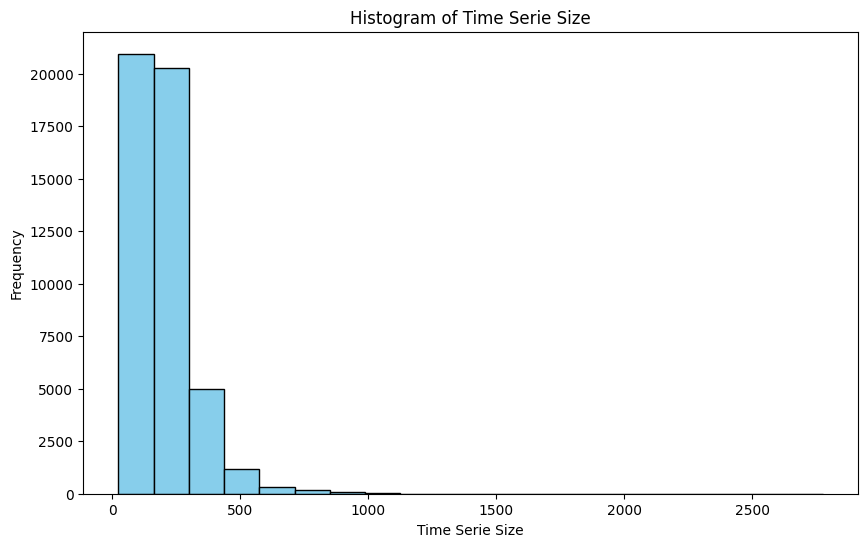

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['time_series_size'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Time Serie Size')
plt.ylabel('Frequency')
plt.title('Histogram of Time Serie Size')

# Show the plot
plt.show()

## Histogram of category distribution

In [ ]:
data['category'][0]

'D'

In [ ]:
category_amount = [0,0,0,0,0,0]
categories = ['A', 'B', 'C', 'D', 'E', 'F']
for i in range(len(data['category'].unique())):
  for j in range(len(data)):
    if data['category'][j] == categories[i]:
      category_amount[i]+=1
print(category_amount)

[5728, 10987, 10017, 10016, 10975, 277]


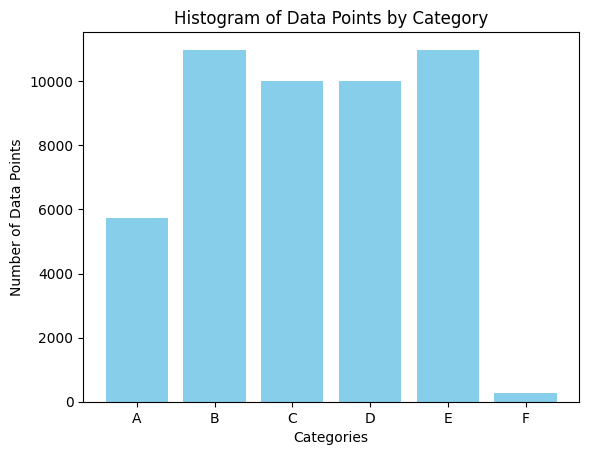

In [ ]:
# Plot the histogram
plt.bar(categories, category_amount)
plt.xlabel('Categories')
plt.ylabel('Number of Data Points')
plt.title('Histogram of Data Points by Category')
plt.show()

##Plot of removed information
We want to get the amount of removed sequences and information removed when we crop the sequences to a certain length

Here we create a vector *incremental_amount_for_length* that, for each number up to the maximum length over all the sequences, states how many sequences shorter than that length there are:

In [ ]:
max_size_value = data['time_series_size'].max()
incremental_amount_for_length  = np.zeros(max_size_value)
for index, row in data.iterrows():
  if index%5000==0:
    print("arrived at index ", index)
  for place in range(row['time_series_size'], max_size_value): #create a vector containing the integer indices up to size of time series
    incremental_amount_for_length[place] += 1
print("Finished")

arrived at index  0
arrived at index  5000
arrived at index  10000
arrived at index  15000
arrived at index  20000
arrived at index  25000
arrived at index  30000
arrived at index  35000
arrived at index  40000
arrived at index  45000
Finished


Here we plot how many SEQUENCES would be removed if we removed all the sequences shorter than the length on x:

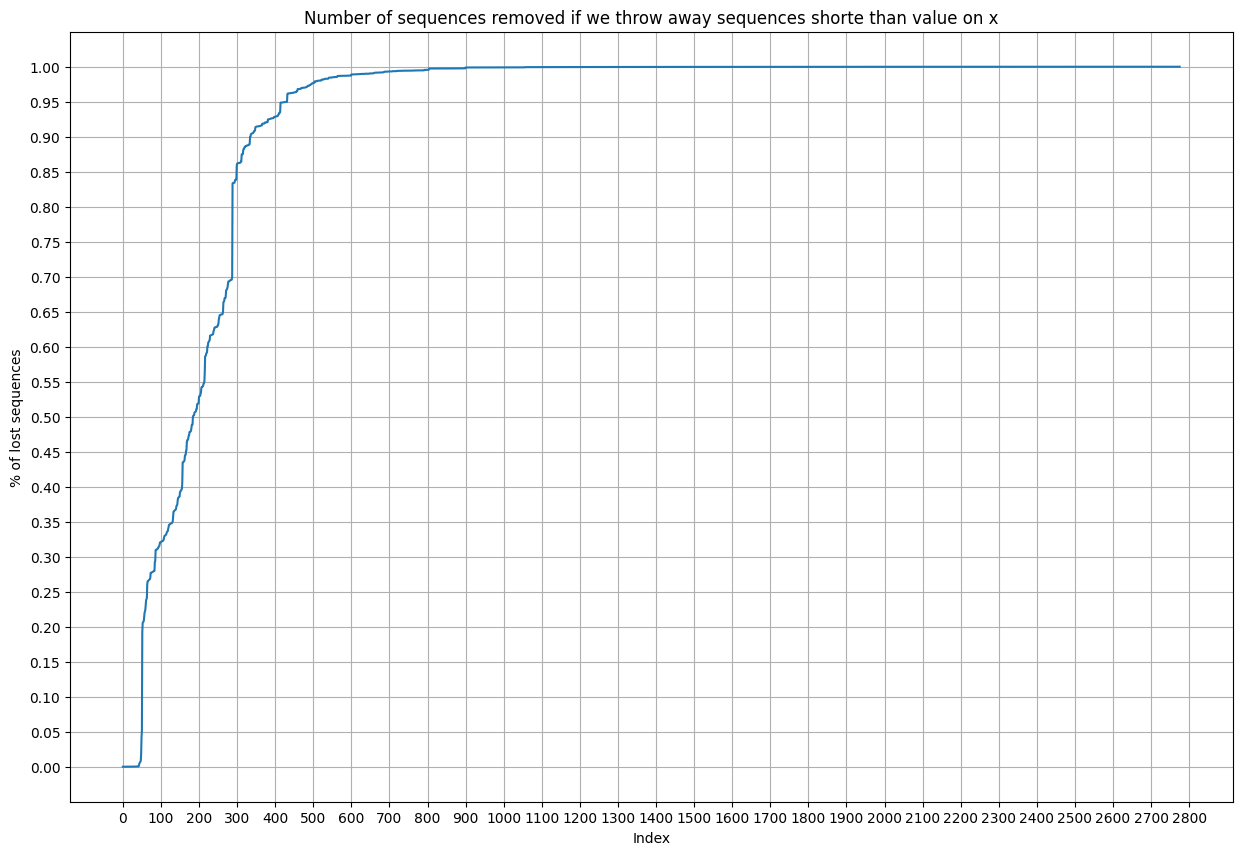

In [ ]:
# Plots percentage of sequences are removed if we crop sequences shorter than length on x axis

incremental_length  = np.zeros(max_size_value)

#normalization
total_length = data.shape[0]

for i in range(len(incremental_amount_for_length)):
  incremental_length[i] = incremental_amount_for_length[i]/total_length

# Plotting the array values
plt.figure(figsize=(15, 10))

plt.plot(incremental_length)
num_ticks = 29
plt.xticks(np.linspace(0, 2800, num_ticks))
num_ticks = 21
plt.yticks(np.linspace(0, 1, num_ticks))

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('% of lost sequences')
plt.title('Number of sequences removed if we throw away sequences shorter than value on x')
plt.grid(True)

# Show the plot
plt.show()

Here we plot how many POINTS would be removed if we removed all the sequences shorter than the length on x:

In [ ]:
#Plotting how many points are removed if we remove sequences shorter than value on x axis

incremental_information  = []

amount=0
for i in range(data['time_series_size'].max()):
  for series in data['time_series_size']:
    if series <= i:
      amount+=series
  incremental_information.append(amount)
  amount=0
  if i%400==0:
    print('Completed ', i, ' out of ', data['time_series_size'].max(), ' iterations')
print("Finished")

print("Length vector (it must be the same as length of longest time series): ", len(incremental_information))
print("Removed information if we remove all the series (it must be equal to total information): ", incremental_information[-1])

amount=0
for i in range(len(data)):
  amount+=data['time_series_size'].iloc[i]
print("total information: ", amount)

Completed  0  out of  2776  iterations
Completed  400  out of  2776  iterations
Completed  800  out of  2776  iterations
Completed  1200  out of  2776  iterations
Completed  1600  out of  2776  iterations
Completed  2000  out of  2776  iterations
Completed  2400  out of  2776  iterations
Finished
Length vector (it must be the same as length of longest time series):  2776
Removed information if we remove all the series (it must be equal to total information):  9515635
total information:  9518411


In [ ]:
#normalization
total_information = 0
for index, row in data.iterrows():
  total_information += row['time_series_size']

normalized_information=np.empty(len(incremental_information))
for i in range(len(incremental_information)):
  normalized_information[i] = incremental_information[i]/total_information



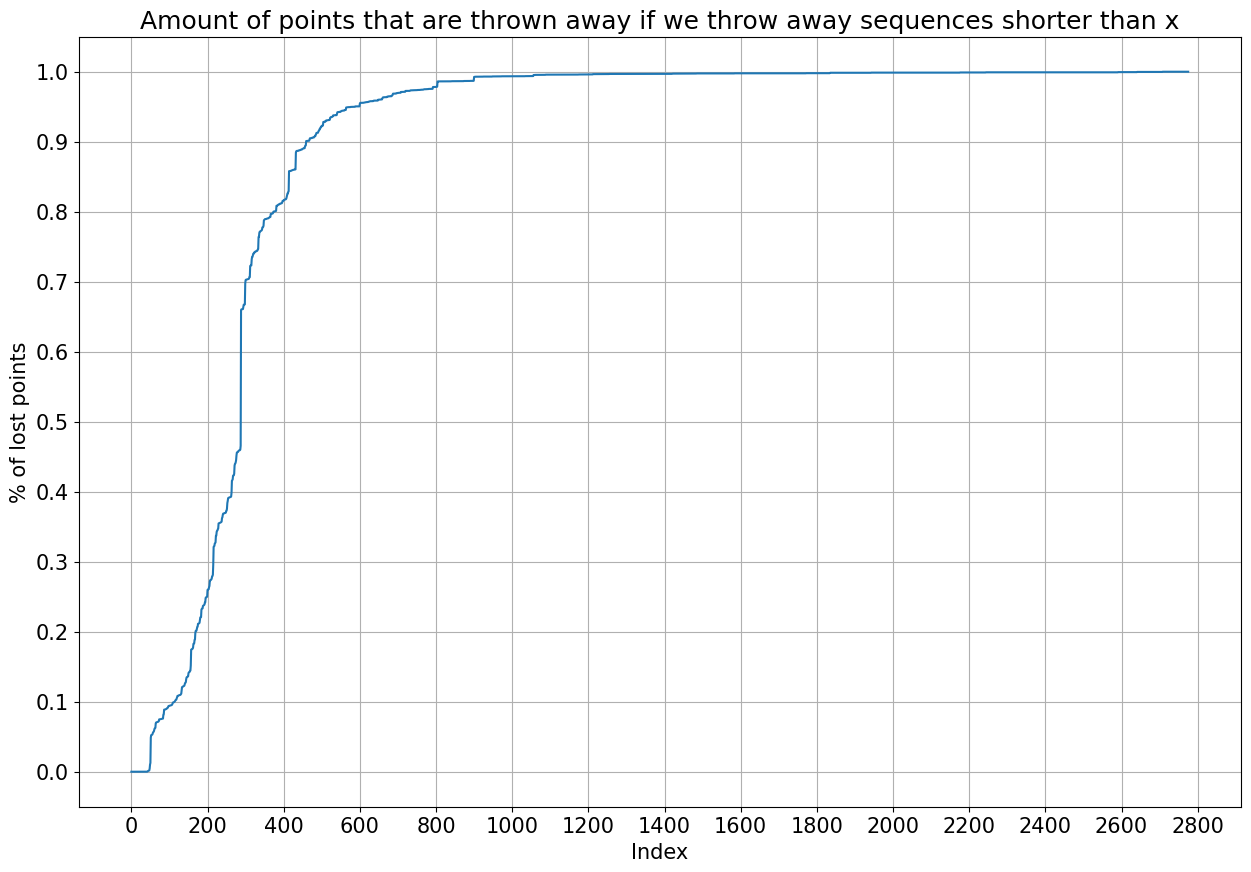

In [ ]:
# Plotting the array values
plt.figure(figsize=(15, 10))

plt.plot(normalized_information)
num_ticks = 15
plt.xticks(np.linspace(0, 2800, num_ticks), fontsize = 15)
num_ticks = 11
plt.yticks(np.linspace(0, 1, num_ticks), fontsize = 15)
# Adding labels and title
plt.xlabel('Index', fontsize = 15)
plt.ylabel('% of lost points', fontsize = 15)
plt.title('Amount of points that are thrown away if we throw away sequences shorter than x', fontsize = 18)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
data.head(20)

,category,time_series,time_series_size
0,D,"[0.49166666666666664, 0.524074074074074, 0.544...",451
1,D,"[0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....",451
2,D,"[0.007403979639055993, 0.0, 0.0179546506247107...",451
3,D,"[1.0, 0.9296987087517934, 0.6527977044476327, ...",64
4,D,"[0.20454545454545456, 0.38636363636363635, 0.2...",94
5,D,"[0.04081632653061224, 0.05102040816326531, 0.0...",648
6,D,"[0.0, 0.08624708624708624, 0.10256410256410256...",94
7,D,"[0.0, 0.075, 0.065, 0.1175, 0.14125, 0.13125, ...",94
8,D,"[0.6078697421981004, 0.6065128900949797, 0.626...",804
9,D,"[0.9289568345323741, 0.947841726618705, 0.9703...",348


We want to understand if the subsequent sequences in the same category have a sort of continuity: we compare the average variation within a sequence with the jump between the last point of the current sequence and the first of the next one (NOTE: we are working with absolute values) (NOTE 2: we still didn't know at the time that the sequences were uncorrelated)

In [ ]:
data['category'].unique()

array(['D', 'E', 'A', 'C', 'B', 'F'], dtype=object)

In [ ]:
# We will work with time_series, so we convert it to float values
data = conv_data_time_series_to_float(data)

In [ ]:
categories = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

total_category_difference = []
total_category_variance = [] #not actually a variance, but average change

for i in range(len(data['category'].unique())):
  category = data['category'].unique()[i]
  print("Beginning category", category)
  differences_category = []
  average_difference_category = []

  # Print total number of time series for each category (for debugging purposes)
  total_category=0
  for index,row in data.iterrows():
    if row['category']==category:
      total_category+=1
  print("category", category, " has ",total_category, " elements")

  counter = 0 #to keep track of number of iterations
  for index, row in data.iterrows():
    sum = 0
    if index < len(data)-1:
      current_row = data.loc[index]
      next_row = data.loc[index+1]
      if current_row['category'] == category and next_row['category'] == category: #compare only if the subsequent sequences belong to the same category

        # progress evaluation
        counter+=1
        if counter%2000 == 0:
          print("Arrived at item ", counter, " over a total of ", total_category)

        #computation of average difference
        for value_index in range(len(current_row['time_series'])-1):
          if value_index+1<=current_row['time_series_size']:
            difference_sequence = np.abs(current_row['time_series'][value_index+1]-current_row['time_series'][value_index])
            sum += difference_sequence
        average_difference = sum/current_row['time_series_size']
        average_difference_category.append(average_difference)

        #store difference between last value of subsequence and the first one of the next
        final_value = current_row['time_series'][-1]
        initial_value = next_row['time_series'][0]
        difference = np.abs(initial_value-final_value)
        differences_category.append(difference)
  #print(differences_category)

  total_category_difference.append(differences_category)
  total_category_variance.append(average_difference_category)

print("Finished")

Beginning category D
category D  has  10016  elements
Arrived at item  2000  over a total of  10016
Arrived at item  4000  over a total of  10016
Arrived at item  6000  over a total of  10016
Arrived at item  8000  over a total of  10016
Arrived at item  10000  over a total of  10016
Beginning category E
category E  has  10975  elements
Arrived at item  2000  over a total of  10975
Arrived at item  4000  over a total of  10975
Arrived at item  6000  over a total of  10975
Arrived at item  8000  over a total of  10975
Arrived at item  10000  over a total of  10975
Beginning category A
category A  has  5728  elements
Arrived at item  2000  over a total of  5728
Arrived at item  4000  over a total of  5728
Beginning category C
category C  has  10017  elements
Arrived at item  2000  over a total of  10017
Arrived at item  4000  over a total of  10017
Arrived at item  6000  over a total of  10017
Arrived at item  8000  over a total of  10017
Arrived at item  10000  over a total of  10017
Be

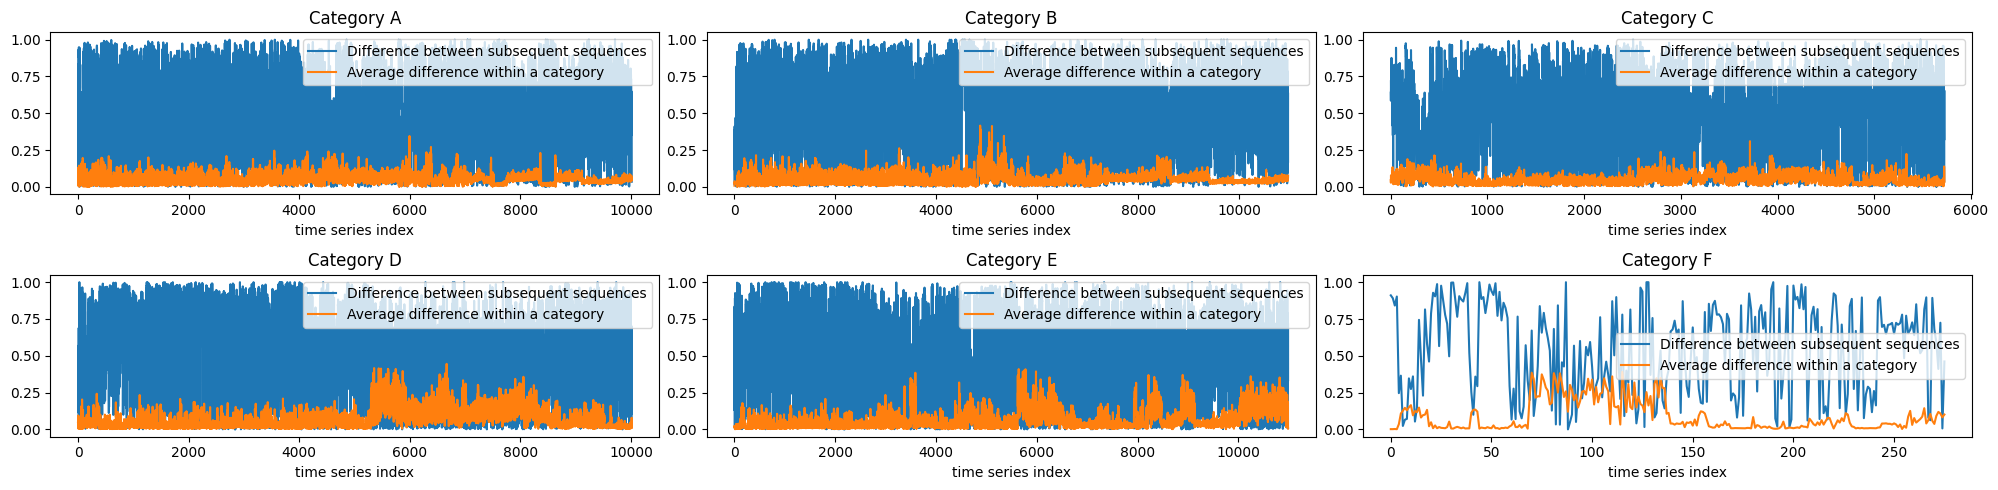

In [ ]:
categories = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

fig, axes = plt.subplots(2, 3, figsize=(20, 5))

for i in range(len(total_category_difference)):
    axes[i // 3, i % 3].plot(range(len(total_category_difference[i])), total_category_difference[i], label='Difference between subsequent sequences')
    axes[i // 3, i % 3].plot(range(len(total_category_variance[i])), total_category_variance[i], label='Average difference within a category')
    string = 'Category ' + categories[i]
    axes[i // 3, i % 3].set_title(string)
    axes[i // 3, i % 3].set_xlabel('time series index')
    axes[i // 3, i % 3].legend()

plt.tight_layout()
plt.show()


We can see from the previous plots that in all the categories the series are probably not in subsequent order, since the difference between the end of one and the beginning of the next is much bigger than the average variation within one series

In [ ]:
del(data)

# Dataset refinement

In [ ]:
data = pd.read_csv('data_raw.csv')
data = conv_data_time_series_to_float(data)

Splitting values and converting to float values
Iteration  0
Iteration  2000
Iteration  4000
Iteration  6000
Iteration  8000
Iteration  10000
Iteration  12000
Iteration  14000
Iteration  16000
Iteration  18000
Iteration  20000
Iteration  22000
Iteration  24000
Iteration  26000
Iteration  28000
Iteration  30000
Iteration  32000
Iteration  34000
Iteration  36000
Iteration  38000
Iteration  40000
Iteration  42000
Iteration  44000
Iteration  46000
Adding float values to the dataframe
Iteration  0


<ipython-input-4-1b8da5a06065>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_series'].iloc[i] = []
<ipython-input-4-1b8da5a06065>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_series'].iloc[i] = lista_float[i]


Iteration  2000
Iteration  4000
Iteration  6000
Iteration  8000
Iteration  10000
Iteration  12000
Iteration  14000
Iteration  16000
Iteration  18000
Iteration  20000
Iteration  22000
Iteration  24000
Iteration  26000
Iteration  28000
Iteration  30000
Iteration  32000
Iteration  34000
Iteration  36000
Iteration  38000
Iteration  40000
Iteration  42000
Iteration  44000
Iteration  46000


## Removal of subsequent initial and final zeros

Removing zeros in sequence at the beginning and at the end of the time series (because we assume that they do not add any information):

In [ ]:
print(data['time_series'].iloc[100][0:20])
print(data.loc[100, 'time_series'][0:20])

[0.0071008672370641585, 0.005529363832140154, 0.009370816599732209, 0.012979454048076336, 0.012863046388452306, 0.007799313194808205, 0.0058785868110121115, 0.006227809789884135, 0.006402421279320179, 0.007857517024620219, 0.004481694895524085, 0.004132471916652063, 0.001920726383796027, 0.0015132995751119893, 0.0, 0.0008148536173680095, 0.0004074268086839717, 0.0034922297887200974, 0.007915720854432168, 0.012979454048076336]
[0.0071008672370641585, 0.005529363832140154, 0.009370816599732209, 0.012979454048076336, 0.012863046388452306, 0.007799313194808205, 0.0058785868110121115, 0.006227809789884135, 0.006402421279320179, 0.007857517024620219, 0.004481694895524085, 0.004132471916652063, 0.001920726383796027, 0.0015132995751119893, 0.0, 0.0008148536173680095, 0.0004074268086839717, 0.0034922297887200974, 0.007915720854432168, 0.012979454048076336]


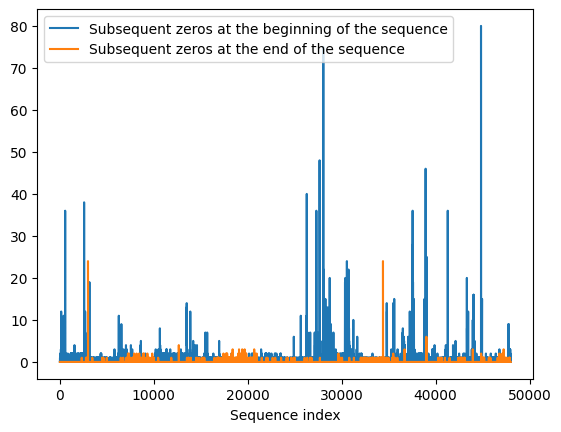

<ipython-input-6-540fc60e2068>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_series'].iloc[i]=data['time_series'].iloc[i][zero_values_beginning[i]:(data['time_series_size'][i]-zero_values_end[i])].copy()


KeyboardInterrupt: ignored

In [ ]:
zero_values_beginning=[]
for item in data['time_series']:
  counter=0
  if item[0]!=0:
    pass
  else:
    while item[counter]==0:
      counter+=1
  zero_values_beginning.append(counter)

plt.plot(zero_values_beginning, label = 'Subsequent zeros at the beginning of the sequence')


zero_values_end=[]
for item in data['time_series']:
  counter=len(item)-1
  real_counter=0
  if item[-1]!=0:
    pass
  else:
    while item[counter]==0:
      counter-=1
      real_counter+=1
  zero_values_end.append(real_counter)

plt.plot(zero_values_end, label = 'Subsequent zeros at the end of the sequence')
plt.xlabel('Sequence index')
plt.legend()
plt.show()


for i in range(len(data['time_series'])):
  data['time_series'].iloc[i]=data['time_series'].iloc[i][zero_values_beginning[i]:(data['time_series_size'][i]-zero_values_end[i])].copy()


# Check that it all worked
zero_values_beginning=[]
for item in data['time_series']:
  counter=0
  if item[0]!=0:
    pass
  else:
    while item[counter]==0:
      counter+=1
  zero_values_beginning.append(counter)

plt.plot(zero_values_beginning, label = 'Subsequent zeros at the beginning of the sequence')

zero_values_end=[]
for item in data['time_series']:
  counter=len(item)-1
  real_counter=0
  if item[-1]!=0:
    pass
  else:
    while item[counter]==0:
      counter-=1
      real_counter+=1
  zero_values_end.append(real_counter)

plt.plot(zero_values_end, label = 'Subsequent zeros at the end of the sequence')
plt.title('Subsequent zeros (check, we expect all zero)')
plt.legend()
plt.ylim(-10,80)
plt.show()

Saving the set with removed zeros (from information in the given dataset + subsequent zeros):

In [ ]:
data.to_csv('time_series_full_no_zeros.csv', index=False)
del(data)

# Classifier dataset

## Build subsequences, not accounting for category

We're building the dataset that will feature a Nx200 matrix for the data (time subsequences) and Nx1 vector containing the label

### Crop the series with less than 200 elements (input shape for the classifier)

In [ ]:
data = pd.read_csv('time_series_full_no_zeros.csv')

Crop of the sequences with less than 200 elements:

In [ ]:
min_length = 200 # 200 input shape for the classifier
data_length = len(data)

#check how many wrong series there are
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print(counter)

for i in range(len(data)):
  if i% 1000==0:
    print("arrived to ", i, " iteration out of ", data_length)
  if data['time_series_size'][i]<min_length:
    #print(i)
    data = data.drop(i)
    #print(len(data))

data = data.reset_index(drop=True)
print("New length of the dataset: ",len(data))


#check again if it worked
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print("Number of series with more than 200 elements (it sould be zero): ", counter)



15395
arrived to  0  iteration out of  48000
arrived to  1000  iteration out of  48000
arrived to  2000  iteration out of  48000
arrived to  3000  iteration out of  48000
arrived to  4000  iteration out of  48000
arrived to  5000  iteration out of  48000
arrived to  6000  iteration out of  48000
arrived to  7000  iteration out of  48000
arrived to  8000  iteration out of  48000
arrived to  9000  iteration out of  48000
arrived to  10000  iteration out of  48000
arrived to  11000  iteration out of  48000
arrived to  12000  iteration out of  48000
arrived to  13000  iteration out of  48000
arrived to  14000  iteration out of  48000
arrived to  15000  iteration out of  48000
arrived to  16000  iteration out of  48000
arrived to  17000  iteration out of  48000
arrived to  18000  iteration out of  48000
arrived to  19000  iteration out of  48000
arrived to  20000  iteration out of  48000
arrived to  21000  iteration out of  48000
arrived to  22000  iteration out of  48000
arrived to  23000 

Save a backup of the dataset without the long series:


In [ ]:
data.to_csv('time_series_crop200_backup.csv', index=False)
del(data)

In [ ]:
data=pd.read_csv('time_series_crop200_backup.csv')

In [ ]:
data

,category,time_series,time_series_size
0,D,"[0.49166666666666664, 0.524074074074074, 0.544...",451
1,D,"[0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....",451
2,D,"[0.007403979639055993, 0.0, 0.0179546506247107...",451
3,D,"[0.04081632653061224, 0.05102040816326531, 0.0...",648
4,D,"[0.6078697421981004, 0.6065128900949797, 0.626...",804
...,...,...,...
32600,F,"[0.7233972240581625, 0.4202467503855475, 0.491...",134
32601,F,"[0.42424607235297657, 0.38247155841810637, 0.2...",134
32602,F,"[0.8157894736842105, 0.8486842105263158, 0.940...",100
32603,F,"[0.5595854922279793, 0.7253886010362695, 0.766...",100


In [ ]:
#Check of balancement

result = np.unique(data['category'], return_counts=True)
unique_values = result[0]
counts = result[1]

print("Unique Values:")
print(unique_values)


print("\nCounts:")
print(counts)

Unique Values:
['A' 'B' 'C' 'D' 'E' 'F']

Counts:
[5565 7078 7443 6734 5584  201]


In [ ]:
time_series = conv_str_to_float(data)

In [ ]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32605 entries, 0 to 32604
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 345.3 MB


In [ ]:
time_series.head()

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.491667,0.524074,0.544444,0.463889,0.406481,0.354630,0.312963,0.366667,0.383333,0.279630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480000,0.500000,0.588000,0.420000,0.288000,0.300000,0.288000,0.516000,0.560000,0.564000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007404,0.000000,0.017955,0.020916,0.027580,0.029246,0.023045,0.024988,0.019250,0.018973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.040816,0.051020,0.051020,0.051020,0.040816,0.040816,0.030612,0.030612,0.030612,0.030612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.607870,0.606513,0.626866,0.621438,0.691995,0.691995,0.691995,0.656716,0.666214,0.662144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(time_series.shape)
print(data['category'].shape)

(32605, 2776)
(32605,)


In [ ]:
#check if dimensions correspond

j=0
for i in range(1,10):
  j=0
  while not np.isnan(time_series.iloc[i][j]):
    j+=1
  print(j)

print(data['time_series_size'])


451
451
648
804
348
600
899
899
708
0        451
1        451
2        451
3        648
4        804
        ... 
32600    134
32601    134
32602    100
32603    100
32604    100
Name: time_series_size, Length: 32605, dtype: int64


### Split in subsequences

In [ ]:
# Build of the subsequences: we generate a column vector containing column vectors of the subsequences

def build_subsequence(time_series, df, window = 200, stride=50):
  vector_a = []
  vector_b = []
  vector_c = []
  vector_d = []
  vector_e = []
  vector_f = []

  subsequence = []
  subsequence_length = window+1

  for i in range(len(df)):
    if i%1000 == 0:
      print("arrived at iteration ", i)
    beginning = 0
    end = beginning + subsequence_length - 1
    while end <= df['time_series_size'][i] - 1:
      #print("end of sequence: ", df['time_series_size'][i])
      #print("end: ", end)
      if not np.isnan(time_series.iloc[i][end]):
        subsequence = np.array(time_series.iloc[i][beginning:end])

        if data['category'][i] == 'A':
          vector_a.append(subsequence)
        elif data['category'][i] == 'B':
          vector_b.append(subsequence)
        elif data['category'][i] == 'C':
          vector_c.append(subsequence)
        elif data['category'][i] == 'D':
          vector_d.append(subsequence)
        elif data['category'][i] == 'E':
          vector_e.append(subsequence)
        elif data['category'][i] == 'F':
          vector_f.append(subsequence)

      beginning += stride
      #end = beginning + subsequence_length - 1
      end += stride

  print("Finished")
  return vector_a, vector_b, vector_c, vector_d, vector_e, vector_f

In [ ]:
vector_a = []
vector_b = []
vector_c = []
vector_d = []
vector_e = []
vector_f = []

vector_a, vector_b, vector_c, vector_d, vector_e, vector_f = build_subsequence(time_series, data)

arrived at iteration  0
arrived at iteration  1000
arrived at iteration  2000
arrived at iteration  3000
arrived at iteration  4000
arrived at iteration  5000
arrived at iteration  6000
arrived at iteration  7000
arrived at iteration  8000
arrived at iteration  9000
arrived at iteration  10000
arrived at iteration  11000
arrived at iteration  12000
arrived at iteration  13000
arrived at iteration  14000
arrived at iteration  15000
arrived at iteration  16000
arrived at iteration  17000
arrived at iteration  18000
arrived at iteration  19000
arrived at iteration  20000
arrived at iteration  21000
arrived at iteration  22000
arrived at iteration  23000
Finished


In [ ]:
vectors = [vector_a, vector_b ,vector_c, vector_d, vector_e, vector_f]
sum=0
for item in vectors:
  print(len(item))
  sum+=len(item)
print("Total number of subsequences: ",sum)

11937
8363
13457
16384
10013
331
Total number of subsequences:  60485


Our dataset will be composed for now by the data itself plus an additional column accounting for the category (it will be useful later when we randomize the order):

In [ ]:
vector_a_df = pd.DataFrame(vector_a)
vector_a_df['category'] = 'A'
vector_b_df = pd.DataFrame(vector_b)
vector_b_df['category'] = 'B'
vector_c_df = pd.DataFrame(vector_c)
vector_c_df['category'] = 'C'
vector_d_df = pd.DataFrame(vector_d)
vector_d_df['category'] = 'D'
vector_e_df = pd.DataFrame(vector_e)
vector_e_df['category'] = 'E'
vector_f_df = pd.DataFrame(vector_f)
vector_f_df['category'] = 'F'

In [ ]:
vector_a_df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,category
0,0.356054,0.256502,0.295964,0.268161,0.208969,0.295067,0.304036,0.256502,0.285202,0.230493,...,0.651121,0.773094,0.897758,0.709417,0.891480,0.789238,0.900448,0.880718,0.813453,A
1,0.005593,0.005593,0.011929,0.010914,0.034561,0.036910,0.032382,0.027191,0.023566,0.023435,...,0.123462,0.130210,0.132841,0.141456,0.148504,0.162772,0.158887,0.156005,0.144799,A
2,0.023877,0.033557,0.043477,0.041870,0.041168,0.042172,0.037975,0.043156,0.036177,0.035906,...,0.188326,0.190214,0.196249,0.222887,0.223660,0.216009,0.199371,0.202675,0.205778,A
3,0.092336,0.092717,0.088982,0.084484,0.085096,0.082526,0.076200,0.065165,0.069352,0.072957,...,0.274497,0.299720,0.305614,0.303274,0.286687,0.291697,0.289759,0.290211,0.277499,A
4,0.120741,0.115641,0.114566,0.117187,0.111122,0.104847,0.108773,0.114797,0.111996,0.118603,...,0.400781,0.396042,0.378942,0.384656,0.385830,0.384706,0.376603,0.383029,0.387447,A


Splitting in train set, validation set, test set:

In [ ]:
train_perc = 0.7
val_perc = 0.15
test_perc = 0.15

In [ ]:
train_class_a = vector_a_df.iloc[:int(vector_a_df.shape[0]*train_perc)]
val_class_a = vector_a_df.iloc[int(vector_a_df.shape[0]*train_perc):int(vector_a_df.shape[0]*(train_perc+val_perc))]
test_class_a = vector_a_df.iloc[int(vector_a_df.shape[0]*(train_perc+val_perc)):]

train_class_b = vector_b_df.iloc[:int(vector_b_df.shape[0]*train_perc)]
val_class_b = vector_b_df.iloc[int(vector_b_df.shape[0]*train_perc):int(vector_b_df.shape[0]*(train_perc+val_perc))]
test_class_b = vector_b_df.iloc[int(vector_b_df.shape[0]*(train_perc+val_perc)):]

train_class_c = vector_c_df.iloc[:int(vector_c_df.shape[0]*train_perc)]
val_class_c = vector_c_df.iloc[int(vector_c_df.shape[0]*train_perc):int(vector_c_df.shape[0]*(train_perc+val_perc))]
test_class_c = vector_c_df.iloc[int(vector_c_df.shape[0]*(train_perc+val_perc)):]

train_class_d = vector_d_df.iloc[:int(vector_d_df.shape[0]*train_perc)]
val_class_d = vector_d_df.iloc[int(vector_d_df.shape[0]*train_perc):int(vector_d_df.shape[0]*(train_perc+val_perc))]
test_class_d = vector_d_df.iloc[int(vector_d_df.shape[0]*(train_perc+val_perc)):]

train_class_e = vector_e_df.iloc[:int(vector_e_df.shape[0]*train_perc)]
val_class_e = vector_e_df.iloc[int(vector_e_df.shape[0]*train_perc):int(vector_e_df.shape[0]*(train_perc+val_perc))]
test_class_e = vector_e_df.iloc[int(vector_e_df.shape[0]*(train_perc+val_perc)):]

train_class_f = vector_f_df.iloc[:int(vector_f_df.shape[0]*train_perc)]
val_class_f = vector_f_df.iloc[int(vector_f_df.shape[0]*train_perc):int(vector_f_df.shape[0]*(train_perc+val_perc))]
test_class_f = vector_f_df.iloc[int(vector_f_df.shape[0]*(train_perc+val_perc)):]

In [ ]:
train_class_a.shape

(8355, 201)

In [ ]:
train_class_b.shape

(5854, 201)

In [ ]:
train_class = pd.concat([train_class_a, train_class_b, train_class_c, train_class_d, train_class_e, train_class_f], axis=0, ignore_index=True)
val_class = pd.concat([val_class_a, val_class_b, val_class_c, val_class_d, val_class_e, val_class_f], axis=0, ignore_index=True)
test_class = pd.concat([test_class_a, test_class_b, test_class_c, test_class_d, test_class_e, test_class_f], axis=0, ignore_index=True)

sum = 0
sum += train_class.shape[0]
sum += val_class.shape[0]
sum += test_class.shape[0]

print("Total number of sequences: ", sum)

Total number of sequences:  60485


Randomizing order of the rows:

In [ ]:
train_class = train_class.sample(frac=1, random_state=42)
val_class_class = val_class.sample(frac=1, random_state=42)
test_class = test_class.sample(frac=1, random_state=42)

Splitting the dataframe in data and label:

In [ ]:
X_train = train_class.iloc[:,0:200]
y_train = train_class.iloc[:,-1]
X_val = val_class.iloc[:,0:200]
y_val = val_class.iloc[:,-1]
X_test = test_class.iloc[:,0:200]
y_test = test_class.iloc[:,-1]

X_train.head(10)
y_train.head(10)

19766    C
6810     A
22451    C
24960    D
20573    C
13608    B
1699     A
30228    D
38872    E
34967    D
Name: category, dtype: object

In [ ]:
X_train.to_csv('dataset_classifier/X_train.csv', index=False)
y_train.to_csv('dataset_classifier/y_train.csv', index=False)
X_val.to_csv('dataset_classifier/X_val.csv', index=False)
y_val.to_csv('dataset_classifier/y_val.csv', index=False)
X_test.to_csv('dataset_classifier/X_test.csv', index=False)
y_test.to_csv('dataset_classifier/y_test.csv', index=False)

Check that the sets are balanced; the output will be a normalized value representing proportion of elements belonging to that class in the set:

In [ ]:
X_train = pd.read_csv('dataset_classifier/X_train.csv')
y_train = pd.read_csv('dataset_classifier/y_train.csv')
X_val = pd.read_csv('dataset_classifier/X_val.csv')
y_val = pd.read_csv('dataset_classifier/y_val.csv')
X_test = pd.read_csv('dataset_classifier/X_test.csv')
y_test = pd.read_csv('dataset_classifier/y_test.csv')

In [ ]:
index = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

amount_train = [0,0,0,0,0,0]
amount_val = [0,0,0,0,0,0]
amount_test = [0,0,0,0,0,0]

sets = [amount_train, amount_val, amount_test]
sets_source = [y_train, y_val, y_test]

for i in range(len(sets)):
  for j in range(len(sets_source[i])):

    sets[i][index[str(sets_source[i].iloc[j][0])]]+=1

  quantity = 0
  for j in range(len(sets[i])):
    quantity += sets[i][j]

  for j in range(len(sets[i])):
    sets[i][j] = sets[i][j]/quantity

for i in range(len(sets)):
  print(sets[i])


[0.1973497732426304, 0.13827475434618292, 0.2224820483749055, 0.27088057445200303, 0.16555650037792896, 0.005456349206349206]
[0.19737712144588934, 0.13819704650650208, 0.2225038571743443, 0.2708838439497465, 0.16552788186026007, 0.00551024906325766]
[0.19735537190082644, 0.13829201101928373, 0.22247933884297522, 0.27085399449035813, 0.16550964187327824, 0.005509641873278237]


In [ ]:
del(data)

#Regressor dataset (cropped)

## Build subsequences saved in divided categories

We're building the dataset for the regressor, divided in train and test set; each category will have its own train and test set, since we want to train 6 different regressors corresponding to each category. The sets will then be divided in the regressor code between input for the net (a matrix Nx200) and the output (a matrix Nx18)

### Crop the series with less than 209 elements (200 window + 9 telescope)

In [ ]:
data = pd.read_csv('time_series_full_no_zeros.csv')

In [ ]:
# Remove series with less than min_length elements

min_length = 209 # 200 input shape + 18 test
data_length = len(data)

#check how many wrong series there are
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print(counter)

for i in range(len(data)):
  if i% 1000==0:
    print("arrived to ", i, " iteration out of ", data_length)
  if data['time_series_size'][i]<min_length:
    data = data.drop(i)

data = data.reset_index(drop=True)
print(len(data))


#check again if it worked
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print(counter)



26030
arrived to  0  iteration out of  48000
arrived to  1000  iteration out of  48000
arrived to  2000  iteration out of  48000
arrived to  3000  iteration out of  48000
arrived to  4000  iteration out of  48000
arrived to  5000  iteration out of  48000
arrived to  6000  iteration out of  48000
arrived to  7000  iteration out of  48000
arrived to  8000  iteration out of  48000
arrived to  9000  iteration out of  48000
arrived to  10000  iteration out of  48000
arrived to  11000  iteration out of  48000
arrived to  12000  iteration out of  48000
arrived to  13000  iteration out of  48000
arrived to  14000  iteration out of  48000
arrived to  15000  iteration out of  48000
arrived to  16000  iteration out of  48000
arrived to  17000  iteration out of  48000
arrived to  18000  iteration out of  48000
arrived to  19000  iteration out of  48000
arrived to  20000  iteration out of  48000
arrived to  21000  iteration out of  48000
arrived to  22000  iteration out of  48000
arrived to  23000 

In [ ]:
len(data)

21970

In [ ]:
data.to_csv('time_series_crop209_backup.csv', index=False)

In [ ]:
data=pd.read_csv('time_series_crop209_backup.csv')

In [ ]:
data

,category,time_series,time_series_size
0,D,"[0.49166666666666664, 0.524074074074074, 0.544...",451
1,D,"[0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....",451
2,D,"[0.007403979639055993, 0.0, 0.0179546506247107...",451
3,D,"[0.04081632653061224, 0.05102040816326531, 0.0...",648
4,D,"[0.6078697421981004, 0.6065128900949797, 0.626...",804
...,...,...,...
21965,F,"[0.006736068585425597, 0.001224739742804654, 0...",482
21966,F,"[0.010303967027305513, 0.021638330757341576, 0...",482
21967,F,"[0.011438474870017331, 0.0076256499133448875, ...",482
21968,F,"[0.002886002886002886, 0.0, 0.0028860028860028...",482


In [ ]:
np.min(data['time_series_size'])

209

In [ ]:
#Check of balancement

result = np.unique(data['category'], return_counts=True)
unique_values = result[0]
counts = result[1]

print("Unique Values:")
print(unique_values)


print("\nCounts:")
print(counts)

Unique Values:
['A' 'B' 'C' 'D' 'E' 'F']

Counts:
[3837 3427 4918 5521 4168   99]


In [ ]:
time_series = conv_str_to_float(data)

0  iterations over  21970
2000  iterations over  21970
4000  iterations over  21970
6000  iterations over  21970
8000  iterations over  21970
10000  iterations over  21970
12000  iterations over  21970
14000  iterations over  21970
16000  iterations over  21970
18000  iterations over  21970
20000  iterations over  21970


In [ ]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21970 entries, 0 to 21969
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 232.7 MB


In [ ]:
time_series

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.491667,0.524074,0.544444,0.463889,0.406481,0.354630,0.312963,0.366667,0.383333,0.279630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480000,0.500000,0.588000,0.420000,0.288000,0.300000,0.288000,0.516000,0.560000,0.564000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007404,0.000000,0.017955,0.020916,0.027580,0.029246,0.023045,0.024988,0.019250,0.018973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.040816,0.051020,0.051020,0.051020,0.040816,0.040816,0.030612,0.030612,0.030612,0.030612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.607870,0.606513,0.626866,0.621438,0.691995,0.691995,0.691995,0.656716,0.666214,0.662144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21965,0.006736,0.001225,0.006124,0.007961,0.017759,0.023270,0.030006,0.039192,0.048377,0.061849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21966,0.010304,0.021638,0.026790,0.040185,0.046883,0.041731,0.043277,0.053581,0.070582,0.081401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21967,0.011438,0.007626,0.007626,0.000000,0.005546,0.004159,0.013172,0.020797,0.027730,0.035702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21968,0.002886,0.000000,0.002886,0.005051,0.015873,0.018759,0.014430,0.007215,0.013709,0.031025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(time_series.shape)
print(data['category'].shape)

(21970, 2776)
(21970,)


In [ ]:
type(time_series)

pandas.core.frame.DataFrame

In [ ]:
time_series.iloc[1][2]

0.588

In [ ]:
#check if dimensions correspond

j=0
for i in range(1,10):
  j=0
  while not np.isnan(time_series.iloc[i][j]):
    j+=1
  print(j)

data['time_series_size']


#Build sequence

451
451
648
804
348
600
899
899
708


0        451
1        451
2        451
3        648
4        804
        ... 
19821    482
19822    482
19823    482
19824    482
19825    751
Name: time_series_size, Length: 19826, dtype: int64

### Split in subsequences

In [ ]:
test=[]
time_series.iloc[0,1:10]
test.append(time_series.iloc[0,1:10])
test

[1    0.524074
 2    0.544444
 3    0.463889
 4    0.406481
 5    0.354630
 6    0.312963
 7    0.366667
 8    0.383333
 9    0.279630
 Name: 0, dtype: float32]

In [ ]:
# Build of the subsequences: we generate a column vector containing column vectors of the subsequences
def build_subsequence(time_series, df, window = 200, telescope=9, stride=50):
  vector_a = []
  vector_b = []
  vector_c = []
  vector_d = []
  vector_e = []
  vector_f = []

  subsequence = []
  subsequence_length = window+telescope+1

  for i in range(len(df)):
    if i%1000 == 0:
      print("arrived at iteration ", i)
    beginning = 0
    end = beginning + subsequence_length - 1
    while end <= df['time_series_size'][i] - 1:
      if not np.isnan(time_series.iloc[i][99]) and np.isnan(time_series.iloc[i][end]):
        j = 0
        while not np.isnan(time_series.iloc[i, j]):
          j += 1
        time_series.iloc[i][j:end] = time_series.iloc[i][0:end-j].copy()
        time_series.iloc[i][0:j] = np.zeros(j)

      if not np.isnan(time_series.iloc[i][end]):
        subsequence = np.array(time_series.iloc[i][beginning:end])

        if data['category'][i] == 'A':
          vector_a.append(subsequence)
        elif data['category'][i] == 'B':
          vector_b.append(subsequence)
        elif data['category'][i] == 'C':
          vector_c.append(subsequence)
        elif data['category'][i] == 'D':
          vector_d.append(subsequence)
        elif data['category'][i] == 'E':
          vector_e.append(subsequence)
        elif data['category'][i] == 'F':
          vector_f.append(subsequence)

      beginning += stride
      #end = beginning + subsequence_length - 1
      end += stride

  print("Finished")
  return vector_a, vector_b, vector_c, vector_d, vector_e, vector_f

In [ ]:
vector_a = []
vector_b = []
vector_c = []
vector_d = []
vector_e = []
vector_f = []


vector_a, vector_b, vector_c, vector_d, vector_e, vector_f = build_subsequence(time_series, data)

arrived at iteration  0
arrived at iteration  1000
arrived at iteration  2000
arrived at iteration  3000
arrived at iteration  4000
arrived at iteration  5000
arrived at iteration  6000
arrived at iteration  7000
arrived at iteration  8000
arrived at iteration  9000
arrived at iteration  10000
arrived at iteration  11000
arrived at iteration  12000
arrived at iteration  13000
arrived at iteration  14000
arrived at iteration  15000
arrived at iteration  16000
arrived at iteration  17000
arrived at iteration  18000
arrived at iteration  19000
arrived at iteration  20000
arrived at iteration  21000
Finished


In [ ]:
vectors = [vector_a, vector_b ,vector_c, vector_d, vector_e, vector_f]
for item in vectors:
  print(len(item))

11578
7886
12879
15773
9720
323


In [ ]:
vector_a_df = pd.DataFrame(vector_a)
vector_b_df = pd.DataFrame(vector_b)
vector_c_df = pd.DataFrame(vector_c)
vector_d_df = pd.DataFrame(vector_d)
vector_e_df = pd.DataFrame(vector_e)
vector_f_df = pd.DataFrame(vector_f)

In [ ]:
vectors_df = [vector_a_df, vector_b_df ,vector_c_df, vector_d_df, vector_e_df, vector_f_df]
for item in vectors_df:
  print(item.shape)

(10625, 218)
(7074, 218)
(10982, 218)
(14569, 218)
(9303, 218)
(281, 218)


In [ ]:
for i in range(len(vector_a_df)):
  if vector_a_df.iloc[i][0] == 0:
    print(vector_a_df.iloc[i])

0      0.000000
1      0.002138
2      0.008885
3      0.027178
4      0.032975
         ...   
213    0.181337
214    0.178367
215    0.185542
216    0.192217
217    0.197159
Name: 14, Length: 218, dtype: float32
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
213    0.666667
214    0.666667
215    0.666667
216    0.666667
217    0.666667
Name: 720, Length: 218, dtype: float32
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
213    0.6
214    0.6
215    0.6
216    0.5
217    0.5
Name: 722, Length: 218, dtype: float32
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
213    0.8
214    0.7
215    0.7
216    0.6
217    0.6
Name: 723, Length: 218, dtype: float32
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
213    0.857143
214    0.714286
215    0.714286
216    0.714286
217    0.571429
Name: 726, Length: 218, dtype: float32
0      0.000000
1      0.026136
2   

In [ ]:
train_a = vector_a_df.iloc[:int(vector_a_df.shape[0]*0.85),:]
test_a = vector_a_df.iloc[int(vector_a_df.shape[0]*0.85):,:]

train_b = vector_b_df.iloc[:int(vector_b_df.shape[0]*0.85),:]
test_b = vector_b_df.iloc[int(vector_b_df.shape[0]*0.85):,:]

train_c = vector_c_df.iloc[:int(vector_c_df.shape[0]*0.85),:]
test_c = vector_c_df.iloc[int(vector_c_df.shape[0]*0.85):,:]

train_d = vector_d_df.iloc[:int(vector_d_df.shape[0]*0.85),:]
test_d = vector_d_df.iloc[int(vector_d_df.shape[0]*0.85):,:]

train_e = vector_e_df.iloc[:int(vector_e_df.shape[0]*0.85),:]
test_e = vector_e_df.iloc[int(vector_e_df.shape[0]*0.85):,:]

train_f = vector_f_df.iloc[:int(vector_f_df.shape[0]*0.85),:]
test_f = vector_f_df.iloc[int(vector_f_df.shape[0]*0.85):,:]


In [ ]:
train_a.to_csv('Data/train209_a.csv', index=False)
test_a.to_csv('Data/test209_a.csv', index=False)
train_b.to_csv('Data/train209_b.csv', index=False)
test_b.to_csv('Data/test209_b.csv', index=False)
train_c.to_csv('Data/train209_c.csv', index=False)
test_c.to_csv('Data/test209_c.csv', index=False)
train_d.to_csv('Data/train209_d.csv', index=False)
test_d.to_csv('Data/test209_d.csv', index=False)
train_e.to_csv('Data/train209_e.csv', index=False)
test_e.to_csv('Data/test209_e.csv', index=False)
train_f.to_csv('Data/train209_f.csv', index=False)
test_f.to_csv('Data/test209_f.csv', index=False)

## Build subsequences saved all together (keeping category information)

We're building the dataset saving all the subsequences in the same file (still divided between train and test), saving in one fiel the subsequences and in the other one the categories. These will be saved only as letters, then they will be one hot encoded in the neural network script. The subsequence set will then be divided in the regressor code between input for the net (a matrix Nx200) and the output (a matrix Nx18).

NOTE: this code must be executed after building class-wise subsequences for the regressor, or when the corresponding files have already been saved

In [ ]:
train_a = pd.read_csv('Data/train209_a.csv')
test_a = pd.read_csv('Data/test209_a.csv')
train_b = pd.read_csv('Data/train209_b.csv')
test_b = pd.read_csv('Data/test209_b.csv')
train_c = pd.read_csv('Data/train209_c.csv')
test_c = pd.read_csv('Data/test209_c.csv')
train_d = pd.read_csv('Data/train209_d.csv')
test_d = pd.read_csv('Data/test209_d.csv')
train_e = pd.read_csv('Data/train209_e.csv')
test_e = pd.read_csv('Data/test209_e.csv')
train_f = pd.read_csv('Data/train209_f.csv')
test_f = pd.read_csv('Data/test209_f.csv')

In [ ]:
test_a.shape

(1737, 209)

In [ ]:
train = pd.concat([train_a, train_b, train_c, train_d, train_e, train_f], axis=0, ignore_index=True)
test = pd.concat([test_a, test_b, test_c, test_d, test_e, test_f], axis=0, ignore_index=True)

sum = 0
sum += train.shape[0]
sum += test.shape[0]

print("Total number of sequences: ", sum)

Total number of sequences:  58159


In [ ]:
train.shape

(49434, 209)

Randomizing order of the rows:

In [ ]:
# Create the dataframe of the classes
classes_train = []
classes_test = []
for _ in range(len(train_a)):
  classes_train.append('A')
for _ in range(len(test_a)):
  classes_test.append('A')

for _ in range(len(train_b)):
  classes_train.append('B')
for _ in range(len(test_b)):
  classes_test.append('B')

for _ in range(len(train_c)):
  classes_train.append('C')
for _ in range(len(test_c)):
  classes_test.append('C')

for _ in range(len(train_d)):
  classes_train.append('D')
for _ in range(len(test_d)):
  classes_test.append('D')

for _ in range(len(train_e)):
  classes_train.append('E')
for _ in range(len(test_e)):
  classes_test.append('E')

for _ in range(len(train_f)):
  classes_train.append('F')
for _ in range(len(test_f)):
  classes_test.append('F')

classes_train = pd.DataFrame(classes_train)
classes_test = pd.DataFrame(classes_test)

classes_train.shape

(49434, 1)

In [ ]:
train = train.sample(frac=1, random_state=42)
test = test.sample(frac=1, random_state=42)

classes_train = classes_train.sample(frac=1, random_state=42)
classes_test = classes_test.sample(frac=1, random_state=42)

In [ ]:
print(train.head(10))

              0         1         2         3         4         5         6  \
32164  0.270506  0.270506  0.228621  0.242583  0.226876  0.233857  0.200698   
199    0.517460  0.539683  0.536508  0.549206  0.380952  0.473016  0.428571   
16026  0.055987  0.060495  0.062399  0.073089  0.069220  0.074361  0.064849   
10791  0.419062  0.428139  0.419062  0.414523  0.408472  0.400908  0.388805   
41290  0.086789  0.098336  0.097715  0.108393  0.107400  0.110007  0.116340   
45761  0.168348  0.169411  0.178173  0.187732  0.185077  0.180828  0.191450   
3085   0.755370  0.790573  0.852625  0.837112  0.814439  0.830549  0.786396   
42625  0.197674  0.261628  0.273256  0.279070  0.296512  0.244186  0.104651   
20565  0.838992  0.806790  0.932530  0.918729  0.311498  0.854326  0.875794   
48648  0.004037  0.006056  0.013626  0.015140  0.019430  0.025990  0.038607   

              7         8         9  ...       199       200       201  \
32164  0.200698  0.183246  0.146597  ...  0.760908  0.69

Splitting the dataframe in data and label:

In [ ]:
train.to_csv('Data/train209.csv', index=False)
test.to_csv('Data/test209.csv', index=False)
classes_train.to_csv('Data/classes_train209.csv', index=False)
classes_test.to_csv('Data/classes_test209.csv', index=False)

# Tests, not finally implemented

## Dataset croppato a 201


In [ ]:
data = pd.read_csv('time_series_full_no_zeros.csv')

In [ ]:
data['time_series_size'][10]

600

In [ ]:
# Remove series with less than min_length elements

min_length = 201 # 200 input shape + 1 label
data_length = len(data)

#check how many wrong series there are
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print(counter)

for i in range(len(data)):
  if i% 1000==0:
    print("arrived to ", i, " iteration out of ", data_length)
  if data['time_series_size'][i]<min_length:
    data = data.drop(i)

data = data.reset_index(drop=True)
print(len(data))


#check again if it worked
counter=0

for item in data['time_series_size']:
  if item < min_length:
    counter += 1
print(counter)



25389
arrived to  0  iteration out of  48000
arrived to  1000  iteration out of  48000
arrived to  2000  iteration out of  48000
arrived to  3000  iteration out of  48000
arrived to  4000  iteration out of  48000
arrived to  5000  iteration out of  48000
arrived to  6000  iteration out of  48000
arrived to  7000  iteration out of  48000
arrived to  8000  iteration out of  48000
arrived to  9000  iteration out of  48000
arrived to  10000  iteration out of  48000
arrived to  11000  iteration out of  48000
arrived to  12000  iteration out of  48000
arrived to  13000  iteration out of  48000
arrived to  14000  iteration out of  48000
arrived to  15000  iteration out of  48000
arrived to  16000  iteration out of  48000
arrived to  17000  iteration out of  48000
arrived to  18000  iteration out of  48000
arrived to  19000  iteration out of  48000
arrived to  20000  iteration out of  48000
arrived to  21000  iteration out of  48000
arrived to  22000  iteration out of  48000
arrived to  23000 

In [ ]:
len(data)

22611

In [ ]:
data.to_csv('time_series_crop201_backup.csv', index=False)

In [ ]:
#Check of balancement

result = np.unique(data['category'], return_counts=True)
unique_values = result[0]
counts = result[1]

print("Unique Values:")
print(unique_values)


print("\nCounts:")
print(counts)

Unique Values:
['A' 'B' 'C' 'D' 'E' 'F']

Counts:
[4087 3600 5037 5564 4223  100]


In [ ]:
time_series = conv_str_to_float(data)

0  iterations over  22611
2000  iterations over  22611
4000  iterations over  22611
6000  iterations over  22611
8000  iterations over  22611
10000  iterations over  22611
12000  iterations over  22611
14000  iterations over  22611
16000  iterations over  22611
18000  iterations over  22611
20000  iterations over  22611
22000  iterations over  22611


In [ ]:
time_series

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.491667,0.524074,0.544444,0.463889,0.406481,0.354630,0.312963,0.366667,0.383333,0.279630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480000,0.500000,0.588000,0.420000,0.288000,0.300000,0.288000,0.516000,0.560000,0.564000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007404,0.000000,0.017955,0.020916,0.027580,0.029246,0.023045,0.024988,0.019250,0.018973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.040816,0.051020,0.051020,0.051020,0.040816,0.040816,0.030612,0.030612,0.030612,0.030612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.607870,0.606513,0.626866,0.621438,0.691995,0.691995,0.691995,0.656716,0.666214,0.662144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22606,0.006736,0.001225,0.006124,0.007961,0.017759,0.023270,0.030006,0.039192,0.048377,0.061849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22607,0.010304,0.021638,0.026790,0.040185,0.046883,0.041731,0.043277,0.053581,0.070582,0.081401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22608,0.011438,0.007626,0.007626,0.000000,0.005546,0.004159,0.013172,0.020797,0.027730,0.035702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22609,0.002886,0.000000,0.002886,0.005051,0.015873,0.018759,0.014430,0.007215,0.013709,0.031025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Build of the subsequences: we generate a column vector containing column vectors of the subsequences
def build_subsequence(time_series, df, window = 200, telescope=18, stride=50):
  vector_a = []
  vector_b = []
  vector_c = []
  vector_d = []
  vector_e = []
  vector_f = []

  subsequence = []
  subsequence_length = window+telescope+1

  for i in range(len(df)):
    if i%1000 == 0:
      print("arrived at iteration ", i)
    beginning = 0
    end = beginning + subsequence_length - 1
    while end <= df['time_series_size'][i] - 1:
      if not np.isnan(time_series.iloc[i][99]) and np.isnan(time_series.iloc[i][end]):
        j = 0
        while not np.isnan(time_series.iloc[i, j]):
          j += 1
        time_series.iloc[i][j:end] = time_series.iloc[i][0:end-j].copy()
        time_series.iloc[i][0:j] = np.zeros(j)

      if not np.isnan(time_series.iloc[i][end]):
        subsequence = np.array(time_series.iloc[i][beginning:end])

        if data['category'][i] == 'A':
          vector_a.append(subsequence)
        elif data['category'][i] == 'B':
          vector_b.append(subsequence)
        elif data['category'][i] == 'C':
          vector_c.append(subsequence)
        elif data['category'][i] == 'D':
          vector_d.append(subsequence)
        elif data['category'][i] == 'E':
          vector_e.append(subsequence)
        elif data['category'][i] == 'F':
          vector_f.append(subsequence)

      beginning += stride
      #end = beginning + subsequence_length - 1
      end += stride

  print("Finished")
  return vector_a, vector_b, vector_c, vector_d, vector_e, vector_f

In [ ]:
vector_a = []
vector_b = []
vector_c = []
vector_d = []
vector_e = []
vector_f = []


vector_a, vector_b, vector_c, vector_d, vector_e, vector_f = build_subsequence(time_series, data, telescope = 1)

arrived at iteration  0
arrived at iteration  1000
arrived at iteration  2000
arrived at iteration  3000
arrived at iteration  4000
arrived at iteration  5000
arrived at iteration  6000
arrived at iteration  7000
arrived at iteration  8000
arrived at iteration  9000
arrived at iteration  10000
arrived at iteration  11000
arrived at iteration  12000
arrived at iteration  13000
arrived at iteration  14000
arrived at iteration  15000
arrived at iteration  16000
arrived at iteration  17000
arrived at iteration  18000
arrived at iteration  19000
arrived at iteration  20000
arrived at iteration  21000
arrived at iteration  22000
Finished


In [ ]:
vectors = [vector_a, vector_b ,vector_c, vector_d, vector_e, vector_f]
for item in vectors:
  print(len(item))

11918
8322
13415
16256
9980
330


In [ ]:
vector_a_df = pd.DataFrame(vector_a)
vector_b_df = pd.DataFrame(vector_b)
vector_c_df = pd.DataFrame(vector_c)
vector_d_df = pd.DataFrame(vector_d)
vector_e_df = pd.DataFrame(vector_e)
vector_f_df = pd.DataFrame(vector_f)

In [ ]:
vectors_df = [vector_a_df, vector_b_df ,vector_c_df, vector_d_df, vector_e_df, vector_f_df]
for item in vectors_df:
  print(item.shape)

(11918, 201)
(8322, 201)
(13415, 201)
(16256, 201)
(9980, 201)
(330, 201)


In [ ]:
for i in range(len(vector_a_df)):
  if vector_a_df.iloc[i][0] == 0:
    print(vector_a_df.iloc[i])

0      0.000000
1      0.002138
2      0.008885
3      0.027178
4      0.032975
         ...   
213    0.181337
214    0.178367
215    0.185542
216    0.192217
217    0.197159
Name: 14, Length: 218, dtype: float32
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
213    0.666667
214    0.666667
215    0.666667
216    0.666667
217    0.666667
Name: 720, Length: 218, dtype: float32
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
213    0.6
214    0.6
215    0.6
216    0.5
217    0.5
Name: 722, Length: 218, dtype: float32
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
213    0.8
214    0.7
215    0.7
216    0.6
217    0.6
Name: 723, Length: 218, dtype: float32
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
213    0.857143
214    0.714286
215    0.714286
216    0.714286
217    0.571429
Name: 726, Length: 218, dtype: float32
0      0.000000
1      0.026136
2   

In [ ]:
train_a = vector_a_df.iloc[:int(vector_a_df.shape[0]*0.85),:]
test_a = vector_a_df.iloc[int(vector_a_df.shape[0]*0.85):,:]

train_b = vector_b_df.iloc[:int(vector_b_df.shape[0]*0.85),:]
test_b = vector_b_df.iloc[int(vector_b_df.shape[0]*0.85):,:]

train_c = vector_c_df.iloc[:int(vector_c_df.shape[0]*0.85),:]
test_c = vector_c_df.iloc[int(vector_c_df.shape[0]*0.85):,:]

train_d = vector_d_df.iloc[:int(vector_d_df.shape[0]*0.85),:]
test_d = vector_d_df.iloc[int(vector_d_df.shape[0]*0.85):,:]

train_e = vector_e_df.iloc[:int(vector_e_df.shape[0]*0.85),:]
test_e = vector_e_df.iloc[int(vector_e_df.shape[0]*0.85):,:]

train_f = vector_f_df.iloc[:int(vector_f_df.shape[0]*0.85),:]
test_f = vector_f_df.iloc[int(vector_f_df.shape[0]*0.85):,:]


In [ ]:
train_a.to_csv('class_dataset/train201_a.csv', index=False)
test_a.to_csv('class_dataset/test201_a.csv', index=False)
train_b.to_csv('class_dataset/train201_b.csv', index=False)
test_b.to_csv('class_dataset/test201_b.csv', index=False)
train_c.to_csv('class_dataset/train201_c.csv', index=False)
test_c.to_csv('class_dataset/test201_c.csv', index=False)
train_d.to_csv('class_dataset/train201_d.csv', index=False)
test_d.to_csv('class_dataset/test201_d.csv', index=False)
train_e.to_csv('class_dataset/train201_e.csv', index=False)
test_e.to_csv('class_dataset/test201_e.csv', index=False)
train_f.to_csv('class_dataset/train201_f.csv', index=False)
test_f.to_csv('class_dataset/test201_f.csv', index=False)

In [ ]:
train = pd.concat([train_a, train_b, train_c, train_d, train_e, train_f], axis=0, ignore_index=True)
test = pd.concat([test_a, test_b, test_c, test_d, test_e, test_f], axis=0, ignore_index=True)

sum = 0
sum += train.shape[0]
sum += test.shape[0]

print("Total number of sequences: ", sum)

Total number of sequences:  60221


In [ ]:
# Create the dataframe of the classes
classes_train = []
classes_test = []
for _ in range(len(train_a)):
  classes_train.append('A')
for _ in range(len(test_a)):
  classes_test.append('A')

for _ in range(len(train_b)):
  classes_train.append('B')
for _ in range(len(test_b)):
  classes_test.append('B')

for _ in range(len(train_c)):
  classes_train.append('C')
for _ in range(len(test_c)):
  classes_test.append('C')

for _ in range(len(train_d)):
  classes_train.append('D')
for _ in range(len(test_d)):
  classes_test.append('D')

for _ in range(len(train_e)):
  classes_train.append('E')
for _ in range(len(test_e)):
  classes_test.append('E')

for _ in range(len(train_f)):
  classes_train.append('F')
for _ in range(len(test_f)):
  classes_test.append('F')

classes_train = pd.DataFrame(classes_train)
classes_test = pd.DataFrame(classes_test)

classes_train.shape

(51185, 1)

In [ ]:
train = train.sample(frac=1, random_state=42)
test = test.sample(frac=1, random_state=42)

classes_train = classes_train.sample(frac=1, random_state=42)
classes_test = classes_test.sample(frac=1, random_state=42)

In [ ]:
train.to_csv('dataset_regressor_no_class/train_201.csv', index=False)
test.to_csv('dataset_regressor_no_class/test_201.csv', index=False)
classes_train.to_csv('dataset_regressor_no_class/classes_train_201.csv', index=False)
classes_test.to_csv('dataset_regressor_no_class/classes_test_201.csv', index=False)

##Padded subsequences

### Build padded subsequences (for the regressor) without cropping

Here we build the dataset cropping out only the subsequences with less than 18 values, since during training and inference they would provide to the net no values; we also save a vector that states from which sequence a sequence has been obtained, for debugging purposes

In [ ]:
data = pd.read_csv('time_series_full_no_zeros.csv')

In [ ]:
data

,category,time_series,time_series_size
0,D,"[0.49166666666666664, 0.524074074074074, 0.544...",451
1,D,"[0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....",451
2,D,"[0.007403979639055993, 0.0, 0.0179546506247107...",451
3,D,"[1.0, 0.9296987087517934, 0.6527977044476327, ...",64
4,D,"[0.20454545454545456, 0.38636363636363635, 0.2...",94
...,...,...,...
47995,F,"[0.7233972240581625, 0.4202467503855475, 0.491...",134
47996,F,"[0.42424607235297657, 0.38247155841810637, 0.2...",134
47997,F,"[0.8157894736842105, 0.8486842105263158, 0.940...",100
47998,F,"[0.5595854922279793, 0.7253886010362695, 0.766...",100


In [ ]:
#Check of balancement

result = np.unique(data['category'], return_counts=True)
unique_values = result[0]
counts = result[1]

print("Unique Values:")
print(unique_values)


print("\nCounts:")
print(counts)

Unique Values:
['A' 'B' 'C' 'D' 'E' 'F']

Counts:
[ 5728 10987 10017 10016 10975   277]


In [ ]:
time_series = conv_str_to_float(data)

0  iterations over  48000
2000  iterations over  48000
4000  iterations over  48000
6000  iterations over  48000
8000  iterations over  48000
10000  iterations over  48000
12000  iterations over  48000
14000  iterations over  48000
16000  iterations over  48000
18000  iterations over  48000
20000  iterations over  48000
22000  iterations over  48000
24000  iterations over  48000
26000  iterations over  48000
28000  iterations over  48000
30000  iterations over  48000
32000  iterations over  48000
34000  iterations over  48000
36000  iterations over  48000
38000  iterations over  48000
40000  iterations over  48000
42000  iterations over  48000
44000  iterations over  48000
46000  iterations over  48000


In [ ]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
time_series

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.491667,0.524074,0.544444,0.463889,0.406481,0.354630,0.312963,0.366667,0.383333,0.279630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480000,0.500000,0.588000,0.420000,0.288000,0.300000,0.288000,0.516000,0.560000,0.564000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007404,0.000000,0.017955,0.020916,0.027580,0.029246,0.023045,0.024988,0.019250,0.018973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000,0.929699,0.652798,0.678623,0.572453,0.598278,0.657102,0.738881,0.558106,0.641320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.204545,0.386364,0.295455,0.454545,0.454545,0.477273,0.454545,0.318182,0.227273,0.318182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0.723397,0.420247,0.491408,0.561357,0.529412,0.546927,0.423111,0.436219,0.577770,0.598810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47996,0.424246,0.382472,0.285078,0.409920,0.462469,0.591705,0.446578,0.545476,0.578222,0.417023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47997,0.815789,0.848684,0.940789,0.881579,0.654605,0.625000,0.562500,0.628289,0.786184,0.796053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47998,0.559586,0.725389,0.766839,0.782383,0.626943,0.652850,0.549223,0.616580,0.704663,0.652850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def pad(subsequence,window,telescope):
  #print(len(subsequence))
  new_subsequence = []
  i=0
  while not np.isnan(subsequence[i]) and i<window+telescope-1:
    i += 1
    #print(i)
  #at this point i describes the position of the first NaN and the number of valid values
  new_subsequence.extend(np.zeros(len(subsequence)-i))
  new_subsequence.extend(subsequence[0:i]) # i value is excluded


  return new_subsequence

With min_length we decide the minimum amount of valid values for each subsequence (put 18 as minimum value):

In [ ]:
# Build of the subsequences: we generate a column vector containing column vectors of the subsequences

def build_subsequence_pad(time_series, df, window = 200, telescope=18, stride=50):
  vector_a = []
  vector_b = []
  vector_c = []
  vector_d = []
  vector_e = []
  vector_f = []

  indices = [] #Array deployed to keep track of the native index. It's just for debugging

  #minimum_length = telescope
  minimum_length = 50

  subsequence = []
  subsequence_length = window+telescope

  i=0

  for i in range(len(time_series)):
    #print(i)
    if i%1000 == 0:
      print("arrived at iteration ", i)
    beginning = 0
    end_index = beginning + subsequence_length - 1
    end = end_index + 1   #when using notation vector[x:y], y value is not included

    flag = 0  # to interrupt the cycle in some occasions

    while end <= np.max(data['time_series_size']) - 1 and flag == 0:
      #if i==592:
        #print('b', beginning)
        #print('e', end)
      #print('first point [',beginning,']: ', time_series.iloc[i][beginning], '; last point [',end,']: ', time_series.iloc[i][end])

      if not np.isnan(time_series.iloc[i][end]):   #if the entire subsequence contains valid values
        subsequence = np.array(time_series.iloc[i][beginning:end])
        if data['category'][i] == 'A':
          vector_a.append(subsequence)
          indices.append(i)
        elif data['category'][i] == 'B':
          vector_b.append(subsequence)
          indices.append(i)
        elif data['category'][i] == 'C':
          vector_c.append(subsequence)
          indices.append(i)
        elif data['category'][i] == 'D':
          vector_d.append(subsequence)
          indices.append(i)
        elif data['category'][i] == 'E':
          vector_e.append(subsequence)
          indices.append(i)
        elif data['category'][i] == 'F':
          vector_f.append(subsequence)
          indices.append(i)
      elif np.isnan(time_series.iloc[i][beginning+minimum_length-1]) and not np.isnan(time_series.iloc[i][beginning]):
         #we discard subsequences with less than minimum_length valid values, we interrupt the cycle
        flag = 1
      elif np.isnan(time_series.iloc[i][end]) and not np.isnan(time_series.iloc[i][beginning]):
        #print('padding ', i)
        subsequence = np.array(time_series.iloc[i][beginning:end])
        if data['category'][i] == 'A':
          vector_a.append(pad(subsequence,window,telescope))
          indices.append(i)
        elif data['category'][i] == 'B':
          vector_b.append(pad(subsequence,window,telescope))
          indices.append(i)
        elif data['category'][i] == 'C':
          vector_c.append(pad(subsequence,window,telescope))
          indices.append(i)
        elif data['category'][i] == 'D':
          vector_d.append(pad(subsequence,window,telescope))
          indices.append(i)
        elif data['category'][i] == 'E':
          vector_e.append(pad(subsequence,window,telescope))
          indices.append(i)
        elif data['category'][i] == 'F':
          vector_f.append(pad(subsequence,window,telescope))
          indices.append(i)
      else:
        #Interrupt the cycle when beginning and end are NaN
        flag = 1


      beginning += stride
      #end = beginning + subsequence_length - 1
      end += stride

  print("Finished")
  return vector_a, vector_b, vector_c, vector_d, vector_e, vector_f, indices

In [ ]:
vector_a = []
vector_b = []
vector_c = []
vector_d = []
vector_e = []
vector_f = []

indices = []

vector_a, vector_b, vector_c, vector_d, vector_e, vector_f,indices = build_subsequence_pad(time_series, data)

arrived at iteration  0
arrived at iteration  1000
arrived at iteration  2000
arrived at iteration  3000
arrived at iteration  4000
arrived at iteration  5000
arrived at iteration  6000
arrived at iteration  7000
arrived at iteration  8000
arrived at iteration  9000
arrived at iteration  10000
arrived at iteration  11000
arrived at iteration  12000
arrived at iteration  13000
arrived at iteration  14000
arrived at iteration  15000
arrived at iteration  16000
arrived at iteration  17000
arrived at iteration  18000
arrived at iteration  19000
arrived at iteration  20000
arrived at iteration  21000
arrived at iteration  22000
arrived at iteration  23000
arrived at iteration  24000
arrived at iteration  25000
arrived at iteration  26000
arrived at iteration  27000
arrived at iteration  28000
arrived at iteration  29000
arrived at iteration  30000
arrived at iteration  31000
arrived at iteration  32000
arrived at iteration  33000
arrived at iteration  34000
arrived at iteration  35000
arriv

In [ ]:
vector_a_df = pd.DataFrame(vector_a)
vector_b_df = pd.DataFrame(vector_b)
vector_c_df = pd.DataFrame(vector_c)
vector_d_df = pd.DataFrame(vector_d)
vector_e_df = pd.DataFrame(vector_e)
vector_f_df = pd.DataFrame(vector_f)

In [ ]:
indices_df = pd.DataFrame(indices)

In [ ]:
def search_padding(sequences):
  padded = []
  for i in range(len(sequences)):
    if sequences.iloc[i][0]==0:
      padded.append(i)
  return padded

In [ ]:
def search_failed(sequences):
  failed = []
  for i in range(len(sequences)):
    if sequences.iloc[i][217]==0:
      failed.append(i)
  return failed

In [ ]:
failed = []
failed = search_failed(vector_d_df)
failed

[4505, 4961, 5240]

In [ ]:
padded = []
padded = search_padding(vector_d_df)
padded

In [ ]:
vectors = [vector_a, vector_b ,vector_c, vector_d, vector_e, vector_f]
for item in vectors:
  print(len(item))

28736
30719
37502
39554
31627
968


In [ ]:
vectors = [vector_a, vector_b ,vector_c, vector_d, vector_e, vector_f]
for item in vectors:
  print(len(item))

32713
37156
42163
44530
36555
1104


In [ ]:
vectors_df = [vector_a_df, vector_b_df ,vector_c_df, vector_d_df, vector_e_df, vector_f_df]
for item in vectors_df:
  print(item.shape)

(28736, 218)
(30719, 218)
(37502, 218)
(39554, 218)
(31627, 218)
(968, 218)


In [ ]:
train_a = vector_a_df.iloc[:int(vector_a_df.shape[0]*0.85),:]
test_a = vector_a_df.iloc[int(vector_a_df.shape[0]*0.85):,:]

train_b = vector_b_df.iloc[:int(vector_b_df.shape[0]*0.85),:]
test_b = vector_b_df.iloc[int(vector_b_df.shape[0]*0.85):,:]

train_c = vector_c_df.iloc[:int(vector_c_df.shape[0]*0.85),:]
test_c = vector_c_df.iloc[int(vector_c_df.shape[0]*0.85):,:]

train_d = vector_d_df.iloc[:int(vector_d_df.shape[0]*0.85),:]
test_d = vector_d_df.iloc[int(vector_d_df.shape[0]*0.85):,:]

train_e = vector_e_df.iloc[:int(vector_e_df.shape[0]*0.85),:]
test_e = vector_e_df.iloc[int(vector_e_df.shape[0]*0.85):,:]

train_f = vector_f_df.iloc[:int(vector_f_df.shape[0]*0.85),:]
test_f = vector_f_df.iloc[int(vector_f_df.shape[0]*0.85):,:]


In [ ]:
train_a.to_csv('padded_dataset/class_division_50/train_a.csv', index=False)
test_a.to_csv('padded_dataset/class_division_50/test_a.csv', index=False)
train_b.to_csv('padded_dataset/class_division_50/train_b.csv', index=False)
test_b.to_csv('padded_dataset/class_division_50/test_b.csv', index=False)
train_c.to_csv('padded_dataset/class_division_50/train_c.csv', index=False)
test_c.to_csv('padded_dataset/class_division_50/test_c.csv', index=False)
train_d.to_csv('padded_dataset/class_division_50/train_d.csv', index=False)
test_d.to_csv('padded_dataset/class_division_50/test_d.csv', index=False)
train_e.to_csv('padded_dataset/class_division_50/train_e.csv', index=False)
test_e.to_csv('padded_dataset/class_division_50/test_e.csv', index=False)
train_f.to_csv('padded_dataset/class_division_50/train_f.csv', index=False)
test_f.to_csv('padded_dataset/class_division_50/test_f.csv', index=False)

Check of correctness (we see if there are no subsequences constituted by only zeros):

In [ ]:
my_data = [0] * 218
test_df = pd.DataFrame([my_data])

test_df

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
failed_vector = []
failed_index = []


vectors_df_test = [test_df]

for vector in vectors_df_test:
  print("arrived at next vector")
  for i in range(len(vector)):
    flag = 0
    if i%100 == 0:
      print(i)
    for j in range(len(vector.iloc[i])):
      if flag == 0:
        if not vector.iloc[i][j] == 0:
          flag = 1
    if not flag:
      failed_vector.append(i)
      print("i ",i)
      failed_index.append(j)
      print("j ",j)


arrived at next vector
0
i  0
j  217


In [ ]:
failed_vector = []
failed_index = []

for vector in vectors_df[]:
  print("arrived at next vector")
  for i in range(len(vector)):
    flag = 0
    if i%100 == 0:
      print(i)
    for j in range(len(vector.iloc[i])):
      if flag == 0:
        if not vector.iloc[i][j] == 0:
          flag = 1
    if not flag:
      failed_vector.append(i)
      print("i ",i)
      failed_index.append(j)
      print("j ",j)


arrived at next vector
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
181

In [ ]:
failed_index

[]

### Build padded subsequences (for the regressor) saved all together (keeping category information)

In [ ]:
train_a = pd.read_csv('padded_dataset/class_division_50/train_a.csv')
test_a = pd.read_csv('padded_dataset/class_division_50/test_a.csv')
train_b = pd.read_csv('padded_dataset/class_division_50/train_b.csv')
test_b = pd.read_csv('padded_dataset/class_division_50/test_b.csv')
train_c = pd.read_csv('padded_dataset/class_division_50/train_c.csv')
test_c = pd.read_csv('padded_dataset/class_division_50/test_c.csv')
train_d = pd.read_csv('padded_dataset/class_division_50/train_d.csv')
test_d = pd.read_csv('padded_dataset/class_division_50/test_d.csv')
train_e = pd.read_csv('padded_dataset/class_division_50/train_e.csv')
test_e = pd.read_csv('padded_dataset/class_division_50/test_e.csv')
train_f = pd.read_csv('padded_dataset/class_division_50/train_f.csv')
test_f = pd.read_csv('padded_dataset/class_division_50/test_f.csv')

In [ ]:
test_a.shape

(4907, 218)

In [ ]:
train = pd.concat([train_a, train_b, train_c, train_d, train_e, train_f], axis=0, ignore_index=True)
test = pd.concat([test_a, test_b, test_c, test_d, test_e, test_f], axis=0, ignore_index=True)

sum = 0
sum += train.shape[0]
sum += test.shape[0]

print("Total number of sequences: ", sum)

Total number of sequences:  169106


In [ ]:
train.shape

(165085, 218)

Randomizing order of the rows:

In [ ]:
# Create the dataframe of the classes
classes_train = []
classes_test = []
for _ in range(len(train_a)):
  classes_train.append('A')
for _ in range(len(test_a)):
  classes_test.append('A')

for _ in range(len(train_b)):
  classes_train.append('B')
for _ in range(len(test_b)):
  classes_test.append('B')

for _ in range(len(train_c)):
  classes_train.append('C')
for _ in range(len(test_c)):
  classes_test.append('C')

for _ in range(len(train_d)):
  classes_train.append('D')
for _ in range(len(test_d)):
  classes_test.append('D')

for _ in range(len(train_e)):
  classes_train.append('E')
for _ in range(len(test_e)):
  classes_test.append('E')

for _ in range(len(train_f)):
  classes_train.append('F')
for _ in range(len(test_f)):
  classes_test.append('F')

classes_train = pd.DataFrame(classes_train)
classes_test = pd.DataFrame(classes_test)

classes_train.shape

(143736, 1)

In [ ]:
train = train.sample(frac=1, random_state=42)
test = test.sample(frac=1, random_state=42)

classes_train = classes_train.sample(frac=1, random_state=42)
classes_test = classes_test.sample(frac=1, random_state=42)

In [ ]:
print(train.head(10))

               0         1         2         3         4         5         6  \
102641  0.270440  0.226415  0.289308  0.301887  0.295597  0.301887  0.301887   
100910  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
81342   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
75876   0.444444  0.296296  0.185185  0.222222  0.259259  0.259259  0.259259   
145538  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
163198  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
43696   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
53157   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8395    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10504   0.537071  0.550934  0.515973  0.514768  0.598553  0.786317  0.714587   

               7         8         9  ...       208       209       210  \
102641  0.308176  0.308176  0.314465  ...  0

Splitting the dataframe in data and label:

In [ ]:
train.to_csv('padded_dataset/no_class_division_50/train.csv', index=False)
test.to_csv('padded_dataset/no_class_division_50/test.csv', index=False)
classes_train.to_csv('padded_dataset/no_class_division_50/classes_train.csv', index=False)
classes_test.to_csv('padded_dataset/no_class_division_50/classes_test.csv', index=False)